In [23]:
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [24]:
basetable = pd.read_csv('basetable_ex2_4.csv')
basetable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   target                 25000 non-null  int64  
 1   gender_F               25000 non-null  int64  
 2   income_high            25000 non-null  int64  
 3   income_low             25000 non-null  int64  
 4   country_USA            25000 non-null  int64  
 5   country_India          25000 non-null  int64  
 6   country_UK             25000 non-null  int64  
 7   age                    25000 non-null  int64  
 8   time_since_last_gift   25000 non-null  int64  
 9   time_since_first_gift  25000 non-null  int64  
 10  max_gift               25000 non-null  float64
 11  min_gift               25000 non-null  float64
 12  mean_gift              25000 non-null  float64
 13  number_gift            25000 non-null  int64  
dtypes: float64(3), int64(11)
memory usage: 2.7 MB


In [25]:
basetable.head(2)

,target,gender_F,income_high,income_low,country_USA,country_India,country_UK,age,time_since_last_gift,time_since_first_gift,max_gift,min_gift,mean_gift,number_gift
0,0,1,0,1,0,1,0,65,530,2265,166.0,87.0,116.0,7
1,0,1,0,0,0,1,0,71,715,715,90.0,90.0,90.0,1


In [43]:
basetable.target.value_counts()

target
0    23813
1     1187
Name: count, dtype: int64

In [44]:
basetable.target.value_counts(normalize=True)

target
0    0.95252
1    0.04748
Name: proportion, dtype: float64

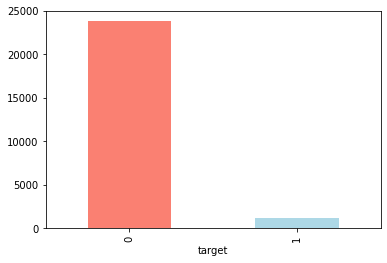

In [45]:
# Plot the value_counts with a bar graph
basetable.target.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [26]:
target_counts = basetable['target'].value_counts()
target_counts

target
0    23813
1     1187
Name: count, dtype: int64

In [27]:
X = basetable[["age", "gender_F", "time_since_last_gift"]]
y = basetable[["target"]]
logreg = linear_model.LogisticRegression()
logreg.fit(X, y)

LogisticRegression()

In [28]:
# Create a dataframe new_data from current_data that has only the relevant predictors 
new_data = X[["age", "gender_F", "time_since_last_gift"]]

# Make a prediction for each observation in new_data and assign it to predictions
predictions = logreg.predict(new_data)
print(predictions[0:5])

[0 0 0 0 0]


### Calculating AUC
- The AUC value assesses how well a model can order observations from low probability to be target to high probability to be target. In Python, the roc_auc_score function can be used to calculate the AUC of the model. It takes the true values of the target and the predictions as arguments. 

In [29]:
# Make predictions
predictions = logreg.predict_proba(X)
predictions_target = predictions[:,-1]

# Calculate the AUC value
auc = roc_auc_score(y, predictions_target)
print(round(auc,2))

0.63


### Using different set of variables to calculate AUC score
- Adding more variables and therefore more complexity to our logistic regression model does not automatically result in more accurate models. Here we can verify whether adding 3 variables to a model leads to a more accurate model.

In [30]:
# Create appropriate dataframes
variables_1 = ['mean_gift', 'income_low']
variables_2 = ['mean_gift', 'income_low', 'gender_F', 'country_India', 'age']

X_1 = basetable[variables_1]
X_2 = basetable[variables_2]
y = basetable[["target"]]

# Create the logistic regression model
logreg = linear_model.LogisticRegression()

# Make predictions using the first set of variables and assign the AUC to auc_1
logreg.fit(X_1, y)
predictions_1 = logreg.predict_proba(X_1)[:,1]
auc_1 = roc_auc_score(y, predictions_1)

# Make predictions using the second set of variables and assign the AUC to auc_2
logreg.fit(X_2, y)
predictions_2 = logreg.predict_proba(X_2)[:,1]
auc_2 = roc_auc_score(y, predictions_2)

# Print auc_1 and auc_2
print(round(auc_1,2))
print(round(auc_2,2))

0.68
0.69


#### We can see that the model with 5 variables has the same AUC as the model using only 2 variables. Adding more variables doesn't always increase the AUC.

## Forward stepwise variable selection : Intutive way of variable selection

### Selecting the next best variable
- The forward stepwise variable selection method starts with an empty variable set and proceeds in steps, where in each step the next best variable is added.
- The **`auc`** function calculates for a given variable set variables the AUC of the model that uses this variable set as predictors. 
- The **`next_best`** function calculates which variable should be added in the next step to the variable list. 
- **Task** :  experiment with these functions to better understand their purpose. We will calculate the AUC of a given variable set, calculate which variable should be added next, and verify that this indeed results in an optimal AUC.

In [31]:
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [32]:
# function to calculate AUC
def auc(variables, target, basetable):
    """calculates AUC"""
    X = basetable[variables]
    y = basetable[target]
    
    logreg = linear_model.LogisticRegression()
    logreg.fit(X,y)
    
    predictions = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(y, predictions)
    return auc

def next_best(current_variable, candidate_variables, target, basetable):
    """function looks throughout candidate variables and keeps track of which  variable is best and the auc associated with the best variable"""
    best_auc = -1
    best_variable = None
    
    # for each variable in the candidate variable set calculate the AUC
    # current_variable : variables which are already in the model
    # extend it with the variable with which we need to evaluate
    for v in candidate_variables:
        auc_v = auc(candidate_variables + [v], target, basetable)
        
    # if this AUC is better then the best AUC, change the best AUC and best variable
    if auc_v >= best_auc:
        best_auc = auc_v
        best_variable = v
    return best_variable

In [33]:
# Calculate the AUC of a model that uses "max_gift", "mean_gift" and "min_gift" as predictors
auc_current = auc(["max_gift", "mean_gift", "min_gift"], ["target"], basetable)
print(round(auc_current,4))

# Calculate which variable among "age" and "gender_F" should be added to the variables "max_gift", "mean_gift" and "min_gift"
next_variable = next_best(["max_gift", "mean_gift", "min_gift"], ["age", "gender_F"], ["target"], basetable)
print(next_variable)

# Calculate the AUC of a model that uses "max_gift", "mean_gift", "min_gift" and "age" as predictors
auc_current_age = auc(["max_gift", "mean_gift", "min_gift", "age"], ["target"], basetable)
print(round(auc_current_age,4))

# Calculate the AUC of a model that uses "max_gift", "mean_gift", "min_gift" and "gender_F" as predictors
auc_current_gender_F = auc(["max_gift", "mean_gift", "min_gift", "gender_F"], ["target"], basetable)
print(round(auc_current_gender_F,4))

0.7126
gender_F
0.7149
0.7131


#### The model that has `gender_F` as next variable has a better AUC than the model that has `age` as next variable. Therefore, `gender_F` is selected as the next best variable.

## Finding the order of variables
- The forward stepwise variable selection procedure starts with an empty set of variables, and adds predictors one by one. In each step, the predictor that has the highest AUC in combination with the current variables is selected. 
- **Task** : implement the forward stepwise variable selection procedure. To this end, we can use the next_best function 

In [34]:
# Find the candidate variables
candidate_variables = list(basetable.columns.values)
candidate_variables.remove("target")
print(candidate_variables)

['gender_F', 'income_high', 'income_low', 'country_USA', 'country_India', 'country_UK', 'age', 'time_since_last_gift', 'time_since_first_gift', 'max_gift', 'min_gift', 'mean_gift', 'number_gift']


In [35]:
# Initialize the current variables
current_variables = []

# The forward stepwise variable selection procedure
number_iterations = 5
for i in range(0, number_iterations):
    next_variable = next_best(current_variables, candidate_variables, ["target"], basetable)
    current_variables = current_variables + [next_variable]
    candidate_variables.remove(next_variable)
    print("Variable added in step " + str(i+1)  + " is " + next_variable + ".")
print(current_variables)

Variable added in step 1 is number_gift.
Variable added in step 2 is mean_gift.
Variable added in step 3 is min_gift.
Variable added in step 4 is max_gift.
Variable added in step 5 is time_since_first_gift.
['number_gift', 'mean_gift', 'min_gift', 'max_gift', 'time_since_first_gift']


## Correlated variables
- The first 10 variables that are added to the model are the following: 
`['max_gift', 'number_gift', 'time_since_last_gift', 'mean_gift', 'income_high', 'age', 'country_USA', 'gender_F', 'income_low', 'country_UK']`
- `min_gift` is not added. Does this mean that it is a bad variable? We can test the performance of the variable by using it in a model as a single variable and calculating the AUC. How does the AUC of `min_gift` compare to the AUC of `income_high`? To this end, we can use the function auc()
- It can happen that a **good variable is not added because it is highly correlated with a variable that is already in the model**. We can test this calculating the correlation between these variables

```python
import numpy
numpy.corrcoef(basetable["variable_1"],basetable["variable_2"])[0,1]
```

In [36]:
import numpy as np

- Calculate the AUC of the model using the variable `min_gift` only.
- Calculate the AUC of the model using the variable `income_high` only.
- Calculate the correlation between the variable `min_gift` and `mean_gift`.

In [37]:
# Calculate the AUC of the model using min_gift only
auc_min_gift = auc(["min_gift"], ["target"], basetable)
print(round(auc_min_gift,2))

# Calculate the AUC of the model using income_high only
auc_income_high = auc(["income_high"], ["target"], basetable)
print(round(auc_income_high,2))

# Calculate the correlation between min_gift and mean_gift
correlation = np.corrcoef(basetable["min_gift"], basetable["mean_gift"])[0,1]
print(round(correlation,2))

0.57
0.52
0.76


####  `min_gift` has more predictive power than `income_high`, but that it is highly correlated with `mean_gift` and therefore not included in the selected variables.

### Partitioning
- In order to properly evaluate a model, one can partition the data in a train and test set. The train set contains the data the model is built on, and the test data is used to evaluate the model. This division is done randomly, but when the target incidence is low, it could be necessary to stratify, that is, to make sure that the train and test data contain an equal percentage of targets. 
- **Task** : partition the data with stratification and verify that the train and test data have equal target incidence.

In [38]:
# Load the partitioning module
from sklearn.model_selection import train_test_split

In [39]:
# # Create dataframes with variables and target
# X = basetable.drop("target", 1)
# y = basetable["target"]

# # Carry out 50-50 partititioning with stratification
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, stratify = y)

# # Create the final train and test basetables
# train = pd.concat([X_train, y_train], axis=1)
# test = pd.concat([X_test, y_test], axis=1)

# # Check whether train and test have same percentage targets
# print(round(sum(train['target'])/len(train), 2))
# print(round(sum(test['target'])/len(test), 2))

In [40]:
# Create dataframes with variables and target
X = basetable.drop("target", axis=1)
y = basetable["target"]

# Carry out 50-50 partitioning with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

# Create the final train and test basetables
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Check whether train and test have same percentage targets
print(round(sum(train['target']) / len(train), 2))
print(round(sum(test['target']) / len(test), 2))


0.05
0.05


#### The stratify option makes sure the target incidence is the same in both train and test.

### Evaluating a model on test and train
- **Task** : apply AUC function, and check whether the train and test AUC are similar.
- Calculate the train and test AUC of the model using `"age"` and `"gender_F"` as predictors using the auc_train_test function.

In [41]:
# Carry out 70-30 partititioning with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

# Create the final train and test basetables
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

auc_train = auc(["age", "gender_F"], "target", train)
auc_test = auc(["age", "gender_F"], "target", test)

print(round(auc_train,2))
print(round(auc_test,2))

0.54
0.57


#### It could happen that the test AUC is slightly lower than the train AUC. This is a perfectly normal phenomenon called over-fitting.

### Building the AUC curves
- **The forward stepwise variable selection procedure provides an order in which variables are optimally added to the predictor set. In order to decide where to cut off the variables, we can make the train and test AUC curves. These curves plot the train and test AUC using the first, first two, first three, ... variables in the model.**
- **Task** : plot these AUC curves
- variables = ['max_gift',
 'time_since_last_gift',
 'number_gift',
 'mean_gift',
 'income_high',
 'age',
 'gender_F',
 'time_since_first_gift',
 'income_low',
 'country_UK']
 
- `auc_values_train`,  will contain the train AUC values of the model at each iteration
- `auc_values_test`, will contain the test AUC values of the model at each iteration
- `variables_evaluate`, will contain the variables evaluated at each iteration

**************************************************************
- Iterate over the variables.
- In each iteration, add the next variable in variables to variables_evaluate.
- In each iteration, calculate the train and test AUC using the auc method. The dataframes train and test contain the train and test data respectively.
- In each iteration, add the calculated values to auc_values_train and auc_values_test

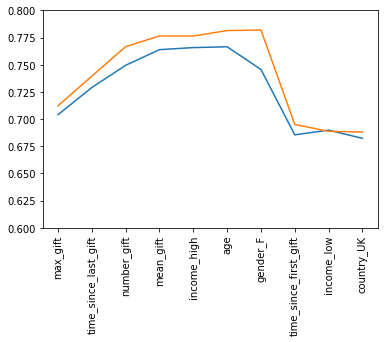

In [42]:
# Keep track of train and test AUC values
auc_values_train = []
auc_values_test = []
variables_evaluate = []

variables = ['max_gift',
 'time_since_last_gift',
 'number_gift',
 'mean_gift',
 'income_high',
 'age',
 'gender_F',
 'time_since_first_gift',
 'income_low',
 'country_UK']

# Iterate over the variables in variables
for v in variables:
  
    # Add the variable
    variables_evaluate.append(v)
    
    # Calculate the train and test AUC of this set of variables
    auc_train = auc(variables_evaluate, "target", train)
    auc_test = auc(variables_evaluate, "target", test)
    
    # Append the values to the lists
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)
    
# Make plot of the AUC values
import matplotlib.pyplot as plt
import numpy as np

x = np.array(range(0,len(auc_values_train)))
y_train = np.array(auc_values_train)
y_test = np.array(auc_values_test)
plt.xticks(x, variables, rotation = 90)
plt.plot(x,y_train)
plt.plot(x,y_test)
plt.ylim((0.6, 0.8))
plt.show()

#### Note that the test AUC curve starts declining sooner than the train curve. The point at which this happens is a good cut-off.